# OpenABM-Covid19 - Recursive Testing

This examples compares contact tracing with and without recursive testing.

In [7]:
import example_utils as utils
import pandas as pd
from math import exp
import numpy as np


# n_total = 1e5
frac_lockdown = 0.05 #0.02
days_lockdown = 60
frac_app_users = 0.75
social_distance_factor = 0.70

In [8]:
def convert_imperial_network_edges_to_oxford_network_edges(network_data):
    network_data.rename(columns = {'a.index': 'ID_1', 'b.index': 'ID_2'}, inplace=True)
    return network_data

def convert_imperial_node_data_to_oxford_node_data(person_node_data, index_to_label_network_with):
    person_node_data.rename(columns = {'index': 'ID',
                                       'household.index': 'house_no',
                                       'age': 'age_group',
                                       'coord.x': 'x',
                                       'coord.y': 'y'}, inplace=True)

    person_node_data['network_no'] = (np.zeros(len(person_node_data)) + index_to_label_network_with)

    # Convert the age to age group (the decade age group of the person and is an integer between 0 (0-9 years) and 8 (80+).)
    person_node_data['age_group'] = person_node_data['age_group'].apply(lambda x: int(x / 10))

    #print(person_node_data) # CA remove

    return person_node_data

##########################
# Load Network Functions #
##########################

# Take path of _nodes.csv
def LoadDemographics(demoPath):
    df_household_demographics = pd.read_csv(demoPath, comment="#", sep=",", skipinitialspace=True)
    # Converting we use network_no=0, as that's for household network
    df_household_demographics = convert_imperial_node_data_to_oxford_node_data(df_household_demographics,0)
    return df_household_demographics

def CoordsFromDemo(df_household_demographics):
    df_coordinates = df_household_demographics.rename(columns={'x':'xcoords','y':'ycoords'})[['ID','xcoords','ycoords']]
    return df_coordinates

def LoadOccupationNetworks(projPath, prefix='bristol'):
    ocNetworksArcs_df_dict = {}
    ocNetworksArcs_colNames = ['ID_1','a.x','a.y','ID_2','b.x','b.y']
    network_name = np.array(['primary', 'secondary', 'general_workforce', 'retired', 'elderly'])

    # Can find network assignment by the a.index for each _i_arcs.csv
    for i,x in enumerate(tqdm(network_name)):
        print([i,x])
        ocNetworksArcs_df_dict[x] = pd.read_csv(projPath+'/'+prefix+"_"+str(i)+"_arcs.csv", comment="#", sep=",", skipinitialspace=True)
        ocNetworksArcs_df_dict[x].columns = ocNetworksArcs_colNames
    
    return ocNetworksArcs_df_dict

###################
# Parameter stuff #
###################

def LoadParams(df_household_demographics, params=None):
    if params == None:
        params = utils.get_baseline_parameters()
    n_total = len(df_household_demographics["ID"])
    params.set_param("n_total", n_total)
    params.set_demographic_household_table(df_household_demographics)
    return params

def LoadNetworks(model, ocNetworksArcs_df_dict, daily_fraction=0.5):
    for i,net in enumerate(ocNetworksArcs_df_dict):
        model.delete_network(model.get_network_by_id(i+2))
        model.add_user_network(ocNetworksArcs_df_dict[net], name=net, daily_fraction=daily_fraction)

def ImperialNetwork(netPath, n_infect=1, prefix='bristol'):
    df_household_demographics = LoadDemographics(netPath+'/'+prefix+'_0_nodes.csv')
    df_coordinates = CoordsFromDemo(df_household_demographics)
    ocNetworksArcs_df_dict = LoadOccupationNetworks(netPath)
    params = LoadParams(df_household_demographics)
    params.set_param("n_seed_infection", n_infect)
    model = utils.get_simulation( params ).env.model
    model.assign_coordinates_individuals(df_coordinates)
    LoadNetworks(model, ocNetworksArcs_df_dict)
    return model

Run the model until `frac_lockdown` of the population are infected.

In [9]:
params = utils.get_baseline_parameters()
params.set_param( "n_total", n_total )
params.set_param( "test_insensitive_period", 3 )
params.set_param( "test_sensitivity", 0.8 )
params.set_param( "test_specificity", 0.99)
params.set_param( "test_release_on_negative", 1)

app_users_param = [ "app_users_fraction_0_9", "app_users_fraction_10_19",  "app_users_fraction_20_29",  
        "app_users_fraction_30_39",  "app_users_fraction_40_49", "app_users_fraction_50_59",    
        "app_users_fraction_60_69",  "app_users_fraction_70_79", "app_users_fraction_80" ]

for age in range(len(app_users_param)):
    params.set_param( app_users_param[age], params.get_param(app_users_param[age])*frac_app_users)

    
# mods
bristol_net_dir = "../../id_spatial_sim/scenarios/bristol/output/networks"

df_household_demographics = pd.read_csv(bristol_net_dir+'/'+'bristol'+'_0_nodes.csv', comment="#", sep=",", skipinitialspace=True)
df_household_demographics = convert_imperial_node_data_to_oxford_node_data(df_household_demographics,0)
params.set_demographic_household_table(df_household_demographics)


    
sim = utils.get_simulation( params )
sim.steps(1)
time_lockdown = 0
while sim.results["total_infected"][ -1] < frac_lockdown * n_total:
    time_lockdown = time_lockdown + 1
    sim.steps(1)

ParameterException: df_demo_house must have n_total rows

Now turn on a lockdown and continue for `days_lockdown` days.

In [3]:
sim.env.model.update_running_params("self_quarantine_fraction", 0.5 )
sim.env.model.update_running_params("quarantine_household_on_symptoms", 1 )
sim.env.model.update_running_params("lockdown_on", 1)
sim.steps( days_lockdown )

Now turn off the lockdown and turn on digitial contract tracing, with the following options.
1. 80% of people self-quarantine along with their household when they develop symptoms.
2. Tracing happens on a positive test
3. The households members of those traced also quarantine

We then run the simimulation for another 100 days.

In [4]:
# lockdown off
sim.env.model.update_running_params("lockdown_on", 0)

# 80% self-quarantine along with their households
sim.env.model.update_running_params("self_quarantine_fraction", 0.8 )
sim.env.model.update_running_params("quarantine_household_on_symptoms", 1 )
  
# turn on the app and quarantine those people who have been traced along with their households
sim.env.model.update_running_params("app_turned_on", 1 )
sim.env.model.update_running_params("quarantine_on_traced", 1 )
sim.env.model.update_running_params("trace_on_positive", 1 )
sim.env.model.update_running_params("trace_on_symptoms", 1 )
sim.env.model.update_running_params("test_on_symptoms", 1 )
sim.env.model.update_running_params("test_on_traced", 1 )
sim.env.model.update_running_params("test_result_wait", 1 )
sim.env.model.update_running_params("test_order_wait", 1 )
sim.env.model.update_running_params("test_release_on_negative", 0 )

sim.env.model.update_running_params("quarantine_household_on_traced_positive", 1 )

# add risk scoring
risk_sd = 3.5
for day in range( 10 ):
    for age_inf in range( 9 ):
        for age_sus in range( 9 ):
            sim.env.model.set_risk_score( day, age_inf, age_sus, exp( 0.5 * ( 1 - day*day / risk_sd/risk_sd ) ) )
     
# apply social distancing measures
sim.env.model.update_running_params("relative_transmission_occupation", social_distance_factor )
sim.env.model.update_running_params("relative_transmission_random", social_distance_factor )

# step forwrard another 100 days
weekly_prev = 1e-3
time = 0
while time < 100:
    time = time+1
    sim.steps(1)
    if pd.DataFrame( sim.results )["total_infected"].diff(7).iloc[-1] < n_total * weekly_prev:
        sim.env.model.update_running_params("test_release_on_negative", 1 )
    else :
        sim.env.model.update_running_params("test_release_on_negative", 0 )


Finally plot the result.

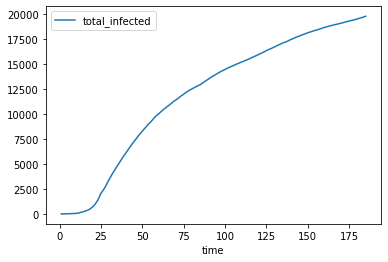

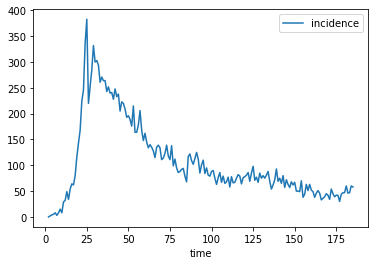

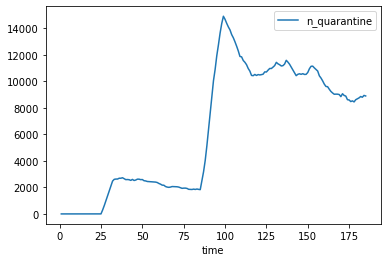

In [5]:
timeseries = pd.DataFrame( sim.results )
timeseries["incidence"] = timeseries["total_infected"].diff()
timeseries.plot( x = "time", y = "total_infected" )
timeseries.plot( x = "time", y = "incidence" )
timeseries.plot( x = "time", y = "n_quarantine" )

In [6]:
# del( sim )